# [ Chapter 9 - Personalized Search ]
# Personalized Search

**NOTE**: This notebook depends upon the the Retrotech dataset. If you have any issues, please rerun the [Setting up the Retrotech Dataset](../ch04/1.setting-up-the-retrotech-dataset.ipyn) notebook or execute the next cell uncommented.

In [1]:
import sys
sys.path.append('..')

In [2]:
import sys
import os
sys.path.append('..')
from aips import *
from datetime import datetime
from IPython.display import display,HTML
from pyspark.conf import SparkConf
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
engine = get_engine()

In [3]:
#Recommended for making ALS run faster, if you have enough memory / cores allocated to docker
conf = SparkConf()
conf.set("spark.driver.memory", "8g")
conf.set("spark.executor.memory", "8g")
conf.set("spark.dynamicAllocation.enabled", "true")
conf.set("spark.dynamicAllocation.executorMemoryOverhead", "8g")
spark = SparkSession.builder.appName("AIPS-ch9").config(conf=conf).getOrCreate()

In [4]:
#%run ../ch04/1.setting-up-the-retrotech-dataset.ipynb

In [5]:
### Load product data
products_collection = engine.get_collection("products")
create_view(products_collection, "products", spark)

# Collaborative Filtering with Implicit Preferences

In [6]:
def aggregate_signals(signals_collection, signals_agg_collection_name, query):
    aggregated_collection = engine.create_collection(signals_agg_collection_name)
    print("Aggregating Signals to Create Signals Boosts...")
    create_view(signals_collection, "signals", spark)
    aggregated_collection.write_from_sql(query, spark)
    print("Signals Aggregation Completed!")
    return aggregated_collection

## Listing 9.1

In [7]:
click_weight = 1
add_to_cart_weight = 0 ##increase to consider add-to-cart signals
purchase_weight = 0 ##increase to consider purchase signals

signals_collection = engine.get_collection("signals")

mixed_signal_types_aggregation = f"""
SELECT user, product,
  (click_boost + add_to_cart_boost + purchase_boost) AS rating
FROM (
  SELECT user, product, 
    SUM(click) AS click_boost,
    SUM(add_to_cart) AS add_to_cart_boost,
    SUM(purchase) AS purchase_boost
  FROM (  
      SELECT s.user, s.target AS product, 
        IF(s.type = 'click', {click_weight}, 0) AS click, 
        IF(s.type = 'add-to-cart', {add_to_cart_weight}, 0) AS add_to_cart,
        IF(s.type = 'purchase', {purchase_weight}, 0) AS purchase
      FROM signals s 
      WHERE (s.type != 'query')
    ) raw_signals
  GROUP BY user, product
) AS per_type_boosts
"""

signals_agg_collection = \
  aggregate_signals(signals_collection, "user_product_implicit_preferences",
                    mixed_signal_types_aggregation)

Wiping "user_product_implicit_preferences" collection
Creating "user_product_implicit_preferences" collection
Status: Success
Aggregating Signals to Create Signals Boosts...
Signals Aggregation Completed!


In [8]:
create_view(signals_agg_collection, "user_product_implicit_preferences", spark)
signals_agg_collection.commit() #sleep for temptable?

<Response [415]>

## Listing 9.2

In [11]:
##50K = all products
#This will take long time. Recommend setting to 1,000 if trying to just run through code
#without considering all products

top_product_count_for_recs = 50000 #1000 for older computers 

user_prefs = spark.sql(f"""
  SELECT user, product, rating FROM user_product_implicit_preferences
  WHERE product IN (
    SELECT product FROM (
      SELECT product, COUNT(user) user_count
      FROM user_product_implicit_preferences
      GROUP BY product
      ORDER BY user_count DESC
      LIMIT {top_product_count_for_recs}
    ) top_products
  )   
  ORDER BY rating DESC""")

## Listing 9.3 

In [12]:
def strings_to_indexes(ratings, user_indexer, product_indexer):
    #Fits a model to the input dataset with optional parameters.
    return product_indexer.transform(user_indexer.transform(ratings))
    
def indexes_to_strings(ratings, user_indexer, product_indexer):
    user_converter = IndexToString(inputCol="userIndex", 
                             outputCol="user", labels=user_indexer.labels)
    product_converter = IndexToString(labels=product_indexer.labels, 
                                outputCol="product", inputCol="productIndex")
    return user_converter.transform(product_converter.transform(ratings))

user_indexer = StringIndexer(inputCol="user", 
                             outputCol="userIndex").fit(user_prefs)
product_indexer = StringIndexer(inputCol="product", outputCol="productIndex").fit(user_prefs)
indexed_prefs = strings_to_indexes(user_prefs, user_indexer, product_indexer)
indexed_prefs.orderBy(col("userIndex").asc(), col("rating").desc()).show(10)

+-------+------------+------+---------+------------+
|   user|     product|rating|userIndex|productIndex|
+-------+------------+------+---------+------------+
|u591943|021331704313|     1|      0.0|       820.0|
|u591943|751492443171|     1|      0.0|       921.0|
|u591943|843163063013|     1|      0.0|       146.0|
|u591943|853469002739|     1|      0.0|       769.0|
|u591943|619659064020|     1|      0.0|       202.0|
|u591943|615104222557|     1|      0.0|       822.0|
|u591943|815227009770|     1|      0.0|       764.0|
|u591943|047875843660|     1|      0.0|        30.0|
| u68500|037648112581|     1|      1.0|       489.0|
| u68500|814916011896|     1|      1.0|       115.0|
+-------+------------+------+---------+------------+
only showing top 10 rows



## Listing 9.4

In [13]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

als = ALS(maxIter=3, rank=10, regParam=0.15, implicitPrefs=True, userCol="userIndex", itemCol="productIndex", ratingCol="rating", coldStartStrategy="drop", seed=0)
#-3939200230093063679

(training, test) = indexed_prefs.randomSplit([0.8, 0.2], 0)

print("Beginning model training")
model = als.fit(indexed_prefs)

print("Beginning predictions")
predictions = model.transform(test)

print("Beginning evaluation")
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")

Beginning model training
Beginning predictions
Beginning evaluation
Root-mean-square error = 0.919510395704779


## Listing 9.5

In [14]:
# Generate top 3 product recommendations for each user
indexed_user_recs = model.recommendForAllUsers(10)
indexed_user_recs.show(5)
#print(predictions.orderBy(col("userIndex").asc(),col("prediction").desc()))

+---------+--------------------+
|userIndex|     recommendations|
+---------+--------------------+
|       31|[{11, 0.03581386}...|
|       53|[{4, 0.16983381},...|
|       65|[{3, 0.15603979},...|
|       78|[{15, 0.056348957...|
|       85|[{8, 0.10333479},...|
+---------+--------------------+
only showing top 5 rows



## Listing 9.6

In [15]:
from pyspark.sql.functions import explode, col

aliased = explode("recommendations").alias("productIndex_rating")
selected = indexed_user_recs.select("userIndex", aliased)
exploded = selected.select("userIndex", col("productIndex_rating.*"))
user_item_recs = indexes_to_strings(exploded, user_indexer, product_indexer) \
    .select("user", "product", col("rating").alias("boost"))

# Listing 9.7

In [16]:
print("Start Time: " + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

#Write recommendations to Solr
recs_collection = engine.create_collection("user_item_recommendations")
user_item_recs.createOrReplaceTempView("temp_user_item_recs")
print("Writing recommendations to Solr...")
recs_collection.write_from_sql("SELECT * FROM temp_user_item_recs", spark)
#faster to use spark.sql than write df directly due to execution plan
#user_item_recs.write.format("solr").options(**opts).mode("overwrite").save()
print("Recommendations saved to table: " + recs_collection.name)

print("End Time: " + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Start Time: 2024-02-12 15:58:36
Wiping "user_item_recommendations" collection
Creating "user_item_recommendations" collection
Status: Success
Writing recommendations to Solr...
Recommendations saved to table: user_item_recommendations
End Time: 2024-02-12 15:59:36


# Search with Recommendations Boosts
Whereas signals boosting boosts the most popular documents for a particular query (ch8), you can also boost the most personalized items for a particular user. In order to serve up the pre-generated collaborative recommendations we just generated, we can just need to run a search and boost the recommended items for each user.

## Listing 9.8

In [17]:
engine = get_engine()
user = "u478462" #example user
signals_collection = engine.get_collection("signals")
products_collection = engine.get_collection("products")
request = {
    "query": "*:*",
    "fields": ["*"],
    "filter": ["user:" + user, "type:query"],
    "sort": "signal_time desc"
}
previous_searches = engine.docs_from_response(signals_collection.search(request))

request = {
    "query": "*:*",
    "fields": ["*"],
    "filter": ["user:" + user, "-type:query"],
    "sort": "signal_time desc"
}
interactions = engine.docs_from_response(signals_collection.search(request))

interacted_products = " ".join(i["target"] for i in interactions)
request = {
    "query": "*:*",
    "fields": ["*"],
    "filter": [f"upc:({interacted_products})"]
}
products = engine.docs_from_response(products_collection.search(request))

product_info = {}
for product in products:
    product_info[product["upc"]] = product["name"] \
        .replace("&#xAE;","®").replace("&#x2122;", "™") #replace encoded version to make more readable

print(f"User: {user}")
print("\nPrevious Searches: ")
for doc in previous_searches:
    print(f'--{doc["target"]}')
    
print("\nPrevious Product Interactions: ")
for i in interactions:
    print(f'--type: {i["type"]}, name: {product_info[i["target"]]}') 

User: u478462

Previous Searches: 
--macbook
--apple

Previous Product Interactions: 
--type: click, name: Apple® - MacBook® Air - Intel® Core™ i5 Processor - 11.6" Display - 4GB Memory - 128GB Flash Storage
--type: purchase, name: Apple® - iPad® 2 with Wi-Fi - 16GB - Black
--type: add-to-cart, name: Apple® - iPad® 2 with Wi-Fi - 16GB - Black
--type: click, name: Apple® - iPad® 2 with Wi-Fi - 16GB - Black


## Listing 9.9

In [18]:
user = "u478462"

recs_collection = engine.get_collection("user_item_recommendations")
def get_query_time_boosts(user, boosts_collection):
    request = {
        "query": "*:*",
        "fields": ["product", "boost"],
        "filter": [f"user:{user}"] if user else [],
        "sort": "boost desc",
        "params": {"rows": 10}
    }
    
    response = boosts_collection.search(request)
    signals_boosts = engine.docs_from_response(response)
    return " ".join(f'"{b["product"]}^{b["boost"] * 100}"' for b in signals_boosts)

def run_main_query(query, signals_boosts, rows):
    request = {
        "query": query if query else "*:*",
        "fields": ["upc", "name", "manufacturer", "score", "shortDescription"],
        "params": {
          "qf": "name manufacturer longDescription", 
          "defType": "edismax",
          "rows": rows if rows else 5,
          "boost": "sum(1,query({! df=upc v=$signals_boosting}))",
          "signals_boosting": signals_boosts if signals_boosts else "*:*"
        }
    }
    return products_collection.search(request)

boosts = get_query_time_boosts(user, recs_collection)
print(f"Boost Query:\n{boosts}")

#recommendations
response = run_main_query(None, boosts, 6)
display_product_search("", engine.docs_from_response(response))

Boost Query:
"885909457588^53.16368" "885909436705^19.299546" "097360810042^8.932165" "635753490879^8.501763" "883974682928^6.1964557000000005" "602527681436^5.34962" "885370325348^3.9618425" "885909395095^3.9074082000000003" "047875843660^3.5775315" "883974845064^3.2654166"


## Listing 9.10

In [19]:
#non-personalized query
query = "tablet"
response = run_main_query(query, None, 7)
print(f"Non-personalized Query")
display_product_search(query, engine.docs_from_response(response))

Non-personalized Query


In [20]:
#personalized query
response = run_main_query(query, boosts, 7)
print(f"Personalized Query")
display_product_search(query, engine.docs_from_response(response))

Personalized Query


# Vector-based Personalization

In [21]:
spark.sql("""SELECT COUNT(upc), COUNT(DISTINCT upc), COUNT(name), COUNT(DISTINCT name), COUNT(DISTINCT shortDescription) FROM products g""").show(2)

+----------+-------------------+-----------+--------------------+--------------------------------+
|count(upc)|count(DISTINCT upc)|count(name)|count(DISTINCT name)|count(DISTINCT shortDescription)|
+----------+-------------------+-----------+--------------------+--------------------------------+
|     48194|              46155|      48194|               46124|                           19024|
+----------+-------------------+-----------+--------------------+--------------------------------+



## Listing 9.11

In [22]:
### Create the product data set for embeddings 
df = spark.sql("""SELECT DISTINCT name, string(upc), shortDescription, 
  CONCAT(name, " ", shortDescription) AS name_desc FROM products""")
df.createOrReplaceTempView("products_samples")
#product_texts=product_dataframe.select("name_desc").rdd.flatMap(lambda x: x).collect()
product_names = df.select("name").rdd.flatMap(lambda x: x).collect()
product_ids = df.select("upc").rdd.flatMap(lambda x: x).collect()


In [23]:
len(product_ids), len(product_names)

(48164, 48164)

In [24]:
from sentence_transformers import SentenceTransformer
transformer = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

## Listing 9.12

In [30]:
import pickle, os
## picked this model "all-mpnet-base-v2" based on benchmark on this link https://medium.com/@nils_reimers/openai-gpt-3-text-embeddings-really-a-new-state-of-the-art-in-dense-text-embeddings-6571fe3ec9d9
transformer = SentenceTransformer("all-mpnet-base-v2")
emb_file = "../data/all-mpnet-base-v2-names-all-embed.data.pkl"
data_file = "../data/all-mpnet-base-v2-names-all-names.data.pkl"
ids_file = "../data/all-mpnet-base-v2-names-all-ids.data.pkl"

###
def get_embeddings(texts, ids, ignore_cache=False):
    load_from_cache = not ignore_cache and os.path.isfile(emb_file) and os.path.isfile(data_file) and os.path.isfile(ids_file)
    if load_from_cache:
        with open(emb_file, "rb") as fd:
            embeddings = pickle.load(fd)
        with open(data_file,"rb") as fd:
            texts = pickle.load(fd)
        with open(ids_file,"rb") as fd:
            ids = pickle.load(fd)
    else:
        embeddings = transformer.encode(texts, convert_to_tensor=False)
        with open(emb_file, "wb") as fd:
            pickle.dump(embeddings, fd)
        with open(data_file, "wb") as fd:
            pickle.dump(texts, fd)
        with open(ids_file, "wb") as fd:
            pickle.dump(ids, fd)
    return embeddings, texts, ids

In [31]:
#product_embeddings=get_embeddings(p_texts,load_from_cache=True)
#product_embeddings=get_embeddings(product_names,load_from_cache=True)
product_embeddings, product_names, product_ids = get_embeddings(product_names, product_ids)

KeyboardInterrupt: 

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 49206)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 253, in poll
    if func():
  File "/usr/local/spark/python/pyspark/accumulators.py", line 257, in accum_updates
    num_updates = read_int(self.rfile)
  File "/usr/local/spark/python/

In [ ]:
### Product Ids-embedding, Product ID-names dictionaries 
product_ids_emb = dict(zip(product_ids, product_embeddings))
product_ids_names = dict(zip(product_ids, product_names))
#len(product_texts), len(product_embeddings), len(product_names) ,len(product_ids),len(product_ids_names.values())
len(product_embeddings), len(product_names), len(product_ids), len(product_ids_names.values())

(48164, 48164, 48164, 46155)

In [ ]:
######## Cluster the product info
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time

## Listing 9.13

In [ ]:
## Get the clusters 
def get_clusters(data, algorithm, args, kwds):
    return algorithm(*args, **kwds).fit(data)

In [ ]:
### K-means clustering
algo = get_clusters(product_embeddings, cluster.KMeans, (),
                    {"n_clusters":100, "n_init":10, "random_state":0})
labels = algo.predict(product_embeddings)
centers = algo.cluster_centers_

In [ ]:
def assign_clusters(labels, product_names):
    clusters = defaultdict(lambda:[], {})
    for i in range(len(labels)):
        clusters[labels[i]].append(product_names[i])
    return clusters

In [ ]:
clusters = assign_clusters(labels, product_names)

In [ ]:
#from sklearn.manifold import TSNE
#X = np.array(centers, dtype=np.float32)
#X.shape
#tsne = TSNE(random_state=0, n_iter=1000)
#tsne_results = tsne.fit_transform(X)
#df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
#df_tsne['Cluster'] = clusters.keys()
#fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
#sns.set_style('darkgrid', {"grid.color": "0.6", "grid.linestyle": ":"})
#sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Cluster', palette='magma')
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#plt.title('Scatter plot of products using KMeans Clustering');
#plt.xlabel('TSNE1');
#plt.ylabel('TSNE2');
#plt.axis('equal')

## Listing 9.14

91

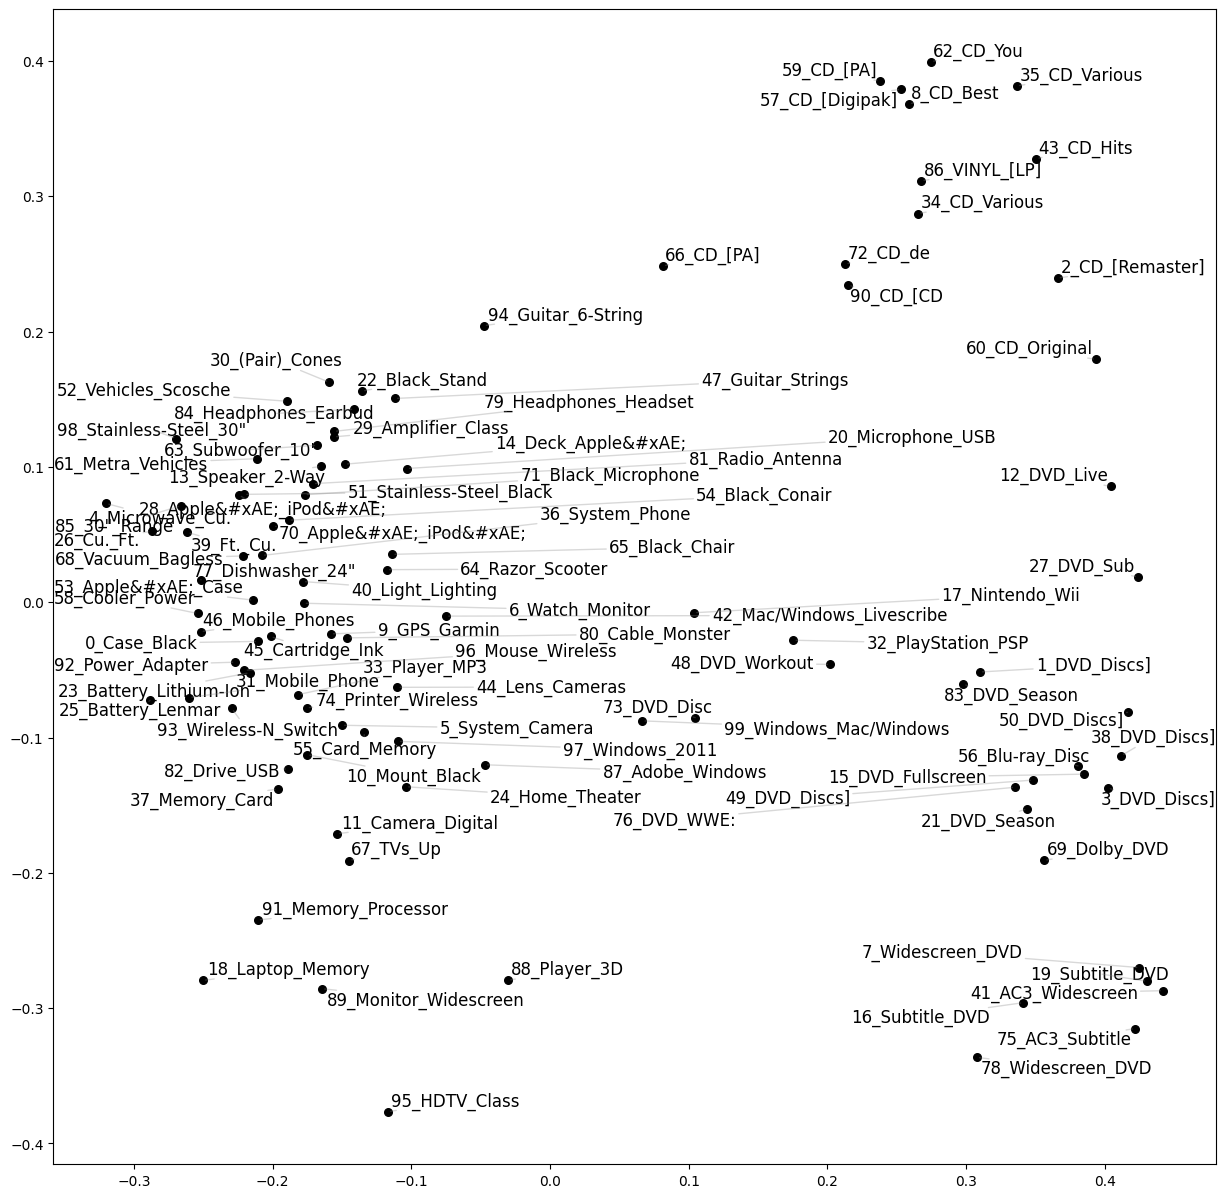

In [ ]:
import collections, itertools, numpy as np, matplotlib.pyplot as plt
from adjustText import adjust_text
from sklearn.decomposition import PCA

stopwords = ["in", "for", "with", "of", "the", "to", "and"]

def top_words(clusters, top_n):
    # Loop through the clusters and split each string on space
    tokenized = [cluster.split() for cluster in clusters]
    # Flatten the list of lists
    flattened = list(itertools.chain.from_iterable(tokenized))
    filtered = [word for word in flattened
                if len(word) > 1 and word.lower() not in stopwords]
    
    # Return the most common words
    return [word for word, _ 
            in collections.Counter(filtered).most_common(top_n)]

#Transform the data for 2-D visualization
plt.figure(figsize=(15,15))
pca = PCA(100, svd_solver="full")
plot_data = pca.fit_transform(centers)
#plot_data = centers
#plt.scatter(plot_data[:,0] , plot_data[:,1] , s = 30, color = 'k')

points = []
for i, cluster_name in enumerate(plot_data):
    plt.scatter(plot_data[i,0], plot_data[i,1], s=30, color="k") 
    label = f"{i}_{'_'.join(top_words(clusters[i], 2))}"
    points.append(plt.text(plot_data[i,0], plot_data[i,1], label, size=12))
adjust_text(points, arrowprops=dict(arrowstyle="-", color="gray", alpha=.3))

In [ ]:
clusters[1]  #useful for spot checking clusters to ensure items inside are homogenous

['Signing Time: Series 2, Vols. 4-7 [4 Discs] - DVD',
 'Mystery Science Theater 3000: Volume 6 [4 Discs] - DVD',
 'Wacky World of Tex Avery: Tex Rides Again - DVD',
 'The Land Before Time - (Full Aniv) - DVD',
 "Sharyn Pak's Desk Sets - DVD",
 'Inside Genesis: A Critical Review - 1975-1980 - Dts - DVD',
 'Time Machine 2011: Live In Cleveland - Blu-ray Disc',
 'ESPN Films 30 for 30 Collection, Vol. 1 [6 Discs] - DVD',
 'Brian Regan: Standing Up - Fullscreen - DVD',
 'Life (Narrated by David Attenborough) [4 Discs] - Subtitle - DVD',
 'The Mound Builders - DVD',
 'Time Machine: Live In Cleveland [Blu-ray Disc] - Blu-ray Disc',
 'Golden Greats of Cricket: Bowlers - DVD',
 'The Ultimate Physics Tutor - Fullscreen - DVD',
 'Eloise Collection, Vol. 1 [3 Discs] - Fullscreen - DVD',
 'Caillou: Caillou the Everyday Hero [Full] - Fullscreen - DVD',
 "Pure Barre, Vol. 1 - Collector's - DVD",
 'Nicholas Byrd: Magic with the iPhone - DVD',
 'Annie Oakley: TV Series 1 - 5 (5pc) - B&W - DVD',
 'Moder

In [ ]:
#sample top keywords in each cluster (same as figure above, but more data)
for cluster_key in range(0,99):
    print(f"{{ cluster: {cluster_key}, top_words: {top_words(clusters[cluster_key], 20)}}}")

{ cluster: 0, top_words: ['Case', 'Black', 'Laptop', 'Sleeve', 'Camera', 'Backpack', 'Bag', 'Accessories', 'M-Edge', 'Jacket', 'Lowepro', 'Digital', 'Kindle', 'Logic', 'Most', 'Keyboard', 'Targus', 'Laptops', 'Apple&#xAE;', 'MacBook&#xAE;']}
{ cluster: 1, top_words: ['DVD', 'Discs]', 'Vol.', 'Collection', '[2', 'Complete', 'Widescreen', 'Disc)', '[4', 'CD', 'Subtitle', 'Series', 'Fullscreen', '[3', 'Box', '(2', 'Dolby', 'Blu-ray', 'Science', 'Disc']}
{ cluster: 2, top_words: ['CD', '[Remaster]', 'Edition)', '(Bonus', '[Bonus', '(Deluxe', 'Tracks]', '(Remastered)', 'DVD]', 'Tracks)', 'Edition]', '[CD', 'Various', '[Deluxe', '[PA]', '(CD+DVD)', 'Vol.', 'Edition', '[Box]', '(Japan)']}
{ cluster: 3, top_words: ['DVD', 'Discs]', '[2', 'Collection', 'Disc)', 'Widescreen', '(2', 'Fullscreen', 'Subtitle', 'Complete', 'Disc', 'Special', 'Blu-ray', 'Vol.', 'Box', '[3', "Collector's", 'Movie', 'Series', '(Ws']}
{ cluster: 4, top_words: ['Microwave', 'Cu.', 'Ft.', 'Over-the-Range', 'Stainless-Stee

In [ ]:
import pandas as pd

### Create Pandas dataframes for product_clusters
product_ids_labels = dict(zip(product_ids, labels))
pddf_product_ids_labels = pd.DataFrame.from_dict(product_ids_labels, orient="index", columns=["label"])
pddf_product_ids_labels["pid"] = pddf_product_ids_labels.index

## Listing 9.15 Comparing approaches for mapping queries to product clusters

In [ ]:
import sentence_transformers, heapq

## get the top n clusters based on similairty with centers 
def get_top_labels_centers(query, centers, n=2):
    q_embedding = transformer.encode([query], convert_to_tensor=False)
    similarities = sentence_transformers.util.cos_sim(q_embedding, centers)
    sim = similarities.tolist()[0]
    return [sim.index(i) for i in heapq.nlargest(n, sim)]

### Get the cluster for the query based on prediction of the label
def get_query_cluster(query):
    q_embedding = transformer.encode([query], convert_to_tensor=False)
    return algo.predict(q_embedding)

In [ ]:
def get_cluster_description(cluser_num):
    return "_".join(top_words(clusters[cluser_num], 5))

query = "microwave"
#option 1: Find nearest cluster (KMeans)
kmeans_predict = get_query_cluster(query)[0]
print("KMeans Predicted Cluster:")
print(f"    {kmeans_predict} ({get_cluster_description(kmeans_predict)})")

#option 2: Find most similar cluster (Cosine similarity)
closest_cosine_similarity = get_top_labels_centers(query, centers, 1)[0]
print(f"""\nCosine Predicted Cluster:\n    {closest_cosine_similarity}
      {get_cluster_description(closest_cosine_similarity)})""")

#option 3: N-nearest clusters (Cosine similarity)
knn_cosine_similarity = get_top_labels_centers(query, centers, 5)
print(f"\nKNN Cosine Predicted Clusters: {knn_cosine_similarity}")
for n in knn_cosine_similarity:
      print(f"    {n} ({get_cluster_description(n)})")

KMeans Predicted Cluster:
    4 (Microwave_Cu._Ft._Over-the-Range_Stainless-Steel)

Cosine Predicted Cluster:
    4
      Microwave_Cu._Ft._Over-the-Range_Stainless-Steel)

KNN Cosine Predicted Clusters: [4, 51, 85, 98, 39]
    4 (Microwave_Cu._Ft._Over-the-Range_Stainless-Steel)
    51 (Stainless-Steel_Black_KitchenAid_Cuisinart_Maker)
    85 (30"_Range_Black_Electric_Freestanding)
    98 (Stainless-Steel_30"_Range_Self-Cleaning_Freestanding)
    39 (Ft._Cu._Refrigerator_Water_Thru-the-Door)


In [ ]:
sdf_id_labels = spark.createDataFrame(pddf_product_ids_labels).createOrReplaceTempView('products_clusters')

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/usr/local/spark/python/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [ ]:
# Load signal data to create user-product vectors
signals_collection = engine.get_collection("signals")
create_view(signals_collection, "signals", spark)

In [ ]:
#Create User-product data set for personalization
spark.sql("""SELECT DISTINCT user, target AS product_id, name AS product_name
FROM signals s JOIN products_samples p ON s.target = p.upc
WHERE s.type = 'click'""").createOrReplaceTempView("user_product")

query = """SELECT user, product_id, product_name, label FROM user_product a
JOIN products_clusters b ON a.product_id = b.pid"""

user_product_cluster_collection = engine.create_collection("user_product_cluster")
user_product_cluster_collection.write_from_sql(query, spark)

Wiping 'user_product_cluster' collection
[('action', 'CREATE'), ('name', 'user_product_cluster'), ('numShards', 1), ('replicationFactor', 1)]
Creating 'user_product_cluster' collection
Status: Success


In [ ]:
## get the top n clusters based on similarity with centers 
def top_clusters_for_embedding(embedding, n=2):
    similarities = sentence_transformers.util.cos_sim(embedding, centers)
    sim = similarities.tolist()[0]
    return [sim.index(i) for i in heapq.nlargest(n, sim)]

## Listing 9.16

In [ ]:
# importiong the modules
import pandas as pd, numpy as np
np.set_printoptions(4)

#Take user's product interests and return dataframe containing embedding and guardrail cluster
def get_user_embeddings(products=[]):
    values = []
    for p in products:
        values.append([product_ids_emb[p], top_clusters_for_embedding(product_ids_emb[p], 1)[0]])
    column_names = ["embedding", "cluster"]
    return pd.DataFrame(data=np.array(values), index=products, columns=column_names)

def get_personalization_vector(query=None, user_items=[], query_weight=1, user_items_weights=[]):
    #by default, weight is split 1:1 (50% each) between the query embedding and the user_items_weight.
    #you can manually add weights for each user_item to influence how much each element counts.

    query_embedding = transformer.encode(query, convert_to_tensor=False) if query else None
    
    if len(user_items) > 0 and len(user_items_weights) == 0:
        user_items_weights = np.full(shape=len(user_items), fill_value=1 / len(user_items))
            
    embeddings = []
    embedding_weights = []
    for weight in user_items_weights:
        embedding_weights.append(weight) 
    for embedding in user_items:
        embeddings.append(embedding)
    if query_embedding.any():
        embedding_weights.append(query_weight)
        embeddings.append(query_embedding)
    
    return np.average(embeddings, weights=np.array(embedding_weights),
                      axis=0).astype("double") if len(embeddings) else None

## Listing 9.17

In [ ]:
product_interests = [ "7610465823828",  #hello kitty water bottle
                      "36725569478"]   #stainless steel electric range

user_embeddings = get_user_embeddings(product_interests)
print(f"\nProducts Interactions for Personalization:\n {user_embeddings}")

query = "microwave"
unfiltered_personalization_vector = get_personalization_vector(query=query,
                        user_items=user_embeddings['embedding'].to_numpy())
print("\nPersonalization Vector (No Cluster Guardrails):")
print(str(unfiltered_personalization_vector[0:5]).replace("]", "... ]"))

query_clusters = get_top_labels_centers(query, centers, n=5)
print("\nQuery Clusters ('microwave'):", query_clusters)

filtered = user_embeddings[user_embeddings.cluster.isin(query_clusters)] #filter down to only items in the query clusters
print("\nProducts Filtered to Query Clusters:\n" + str(filtered))

filtered_personalization_vector = get_personalization_vector(query=query,
                             user_items=filtered['embedding'].to_numpy())

print("\nFiltered Personalization Vector (With Cluster Guardrails):")
print(str(filtered_personalization_vector[0:5]).replace("]", "... ]"))


Products Interactions for Personalization:
                                                        embedding cluster
7610465823828  [0.06417941, 0.04178553, -0.0017139615, -0.020...      54
36725569478    [0.0055417763, -0.024302201, -0.024139373, -0....      98

Personalization Vector (No Cluster Guardrails):
[ 0.0164 -0.0062 -0.02   -0.0317 -0.0161... ]

Query Clusters ('microwave'): [4, 51, 85, 98, 39]

Products Filtered to Query Clusters:
                                                     embedding cluster
36725569478  [0.0055417763, -0.024302201, -0.024139373, -0....      98

Filtered Personalization Vector (With Cluster Guardrails):
[ 0.0018 -0.0227 -0.0256 -0.0369 -0.0254... ]


/tmp/ipykernel_45/118144447.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return pd.DataFrame(data=np.array(values), index=products, columns=column_names)


## Listing 9.18

In [ ]:
# 4- Get all items for the search query using solr index
## Get the top items from the query cluster for the user
### User search query using solr 
#query="Western Digital - Scorpio Blue 250GB Internal Serial ATA Hard Drive for Laptops Serial ATA interface; quiet performance; 1.5GB/sec data transfer rate"

query = "microwave"
request = {
    "query": query, 
    "fields": ["upc", "name", "manufacturer", "score"], 
    "sort": "score desc, upc asc",
    "params": {
        "qf": "name manufacturer",
        "defType": "edismax",
        "rows": 100
    }
}

response = products_collection.search(request)
docs = engine.docs_from_response(response)
print("Search Results w/ No Personalization:")
display_product_search(query, docs[0:4])

Search Results w/ No Personalization:


In [ ]:
from operator import itemgetter

def rerank_with_personalization(docs, personalization_vector):
    result_embeddings = np.array([product_ids_emb[docs[x]['upc']]
                                  for x in range(len(docs))]).astype(float)
    similarities = sentence_transformers.util.cos_sim(
        personalization_vector, result_embeddings).tolist()[0]
    reranked = [similarities.index(i)
                for i in heapq.nlargest(len(similarities), similarities)]
    reranked, _ = zip(*sorted(enumerate(similarities),
                              key=itemgetter(1), reverse=True))
    return [docs[i] for i in reranked]
   
print("Personalized search results (no category guardrails):")
reranked_seach_results_no_guardrails = \
    rerank_with_personalization(docs, unfiltered_personalization_vector) 
display_product_search(query, reranked_seach_results_no_guardrails[0:4])

print("Personalized search results (with category guardrails):")
reranked_seach_results_with_guardrails = \
    rerank_with_personalization(docs, filtered_personalization_vector) 
display_product_search(query, reranked_seach_results_with_guardrails[0:4])


Personalized search results (no category guardrails):


Personalized search results (with category guardrails):


Up next: Chapter 10 - [Learning to Rank for Generalizable Search Relevance](../ch10/1.setup-the-movie-db.ipynb)